In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from utils.code_exercise1 import my_window, get_fundamental_freq
from utils.code_exercise3 import get_a_vector, get_b0, inspect_segment_lpc
from scipy.signal import get_window

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# Section 1

In [2]:
y, sr = librosa.core.load("data/exercise4/female8khz.wav", sr=None)

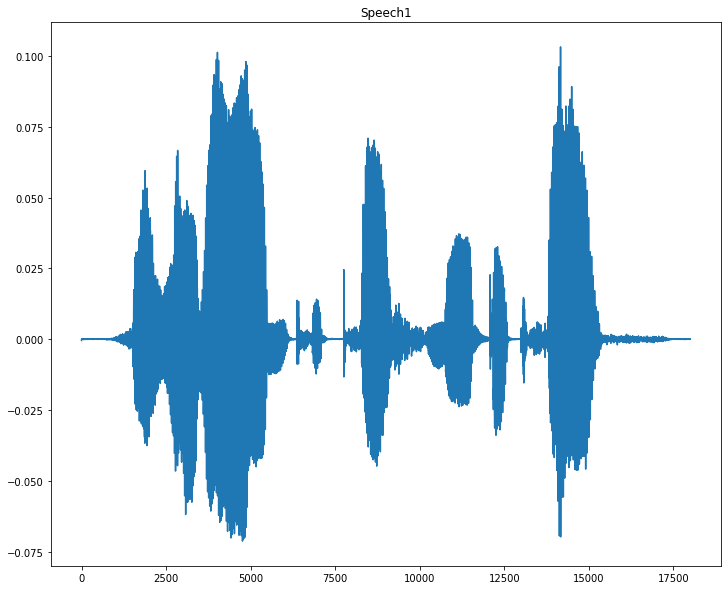

In [3]:
plt.figure(figsize=(12,10))
plt.title("Speech1")
plt.plot(y)

In [4]:
time = np.linspace(0, len(y) / sr, num=len(y))

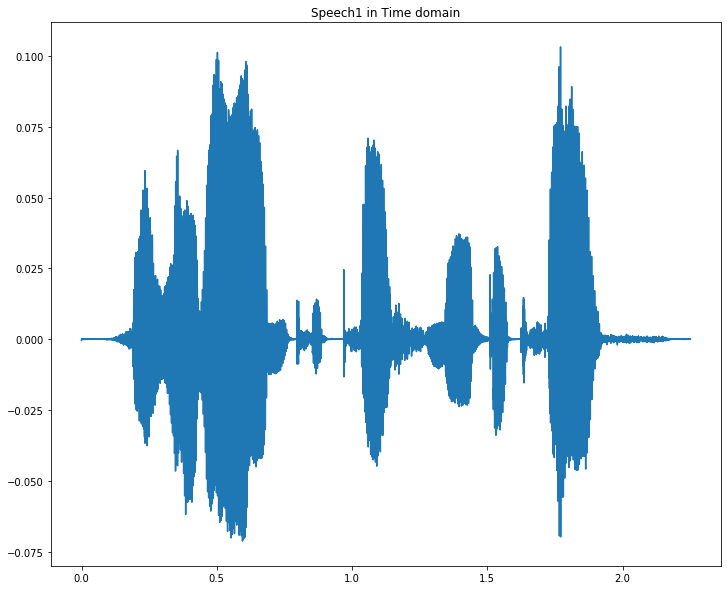

In [5]:
plt.figure(figsize=(12,10))
plt.title("Speech1 in Time domain")
plt.plot(time, y)

In [6]:
sr

8000

In [7]:
import sounddevice
sounddevice.play(y, sr)

# Section 3

## Note: See get_fundamental_freq function from  utils/code_exercise_1.py 

In [8]:
f0_1, time = get_fundamental_freq(y, sr)

/Users/christoper/programming/python/ssp/utils/code_exercise1.py:37: RuntimeWarning: divide by zero encountered in true_divide
  freqs = np.ones(periods.shape[0]) / periods


Text(0.5, 0, 'seconds')

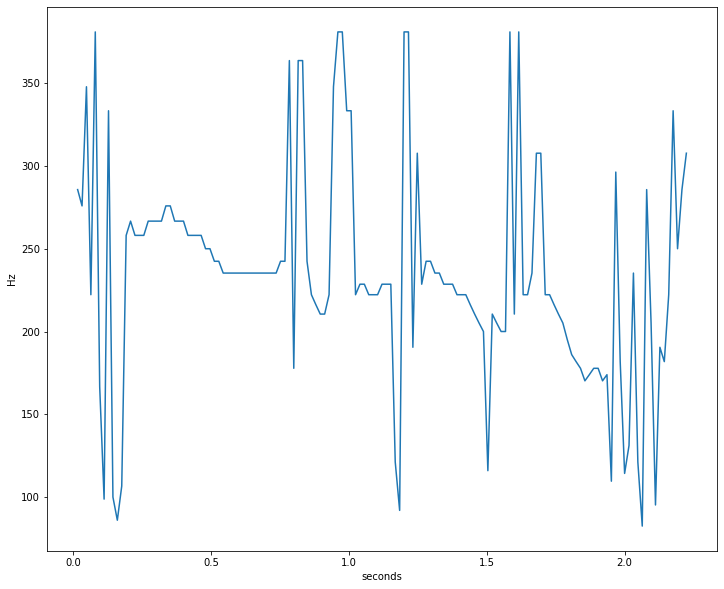

In [9]:
plt.figure(figsize=(12,10))
plt.plot(time, f0_1)
plt.ylabel("Hz")
plt.xlabel("seconds")

In [10]:
def compute_stft(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int, v_analysis_window: np.ndarray):
    segments, v_time = my_window(v_signal, sampling_rate, frame_length, frame_shift)
    
    seg_windows = segments * v_analysis_window
    
    n_length = int(sampling_rate * frame_length / 1000) 
    freqs = np.fft.fftfreq(n_length)
    
    m_stft = np.fft.fft(seg_windows)[:,:(n_length//2 +1)] # consider only lower half of the spectrum
    
    v_freq = freqs[:n_length//2] * sampling_rate
    
    return m_stft, v_freq, v_time

In [11]:
def plot_spectrum(m_stft, v_freq, v_time):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    im = ax.imshow(10* np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**( -15))),
                    cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                    v_freq [ -1]] , aspect ='auto')
    fig.colorbar(im , orientation ="vertical", pad =0.2)

In [12]:
frame_length = 32
frame_shift = 8
n_length = int(sr * frame_length / 1000) 
hann_win = get_window('hann', n_length)

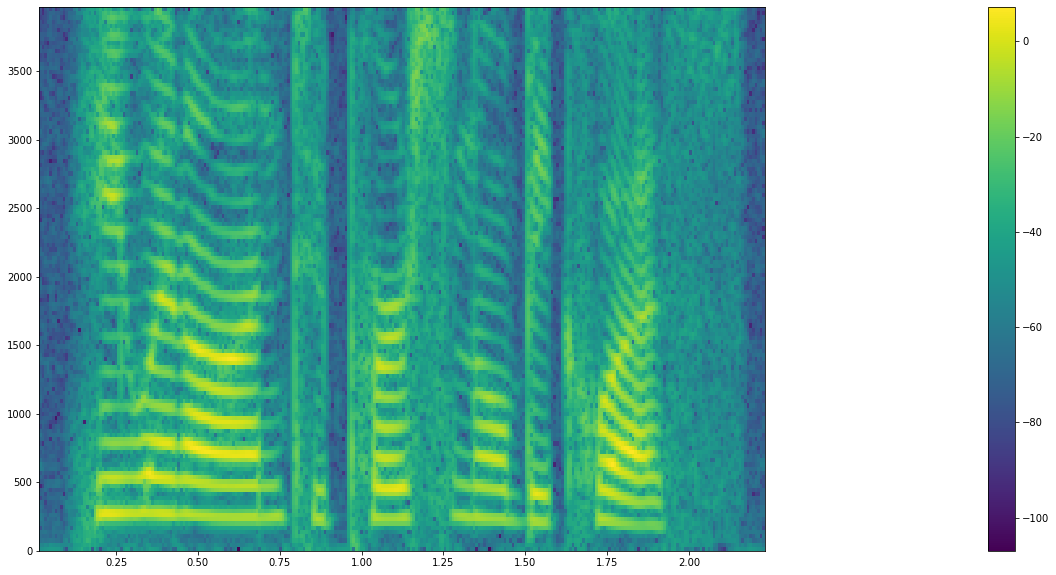

In [13]:
m_stft, v_freq, v_time = compute_stft(y, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

In [14]:
def power(segment):
    return (1.0/len(segment)) * np.power(segment, 2).sum()

In [15]:
segments, v_time = my_window(y, sr, frame_length, frame_shift)

In [16]:
power = np.apply_along_axis(power, 1, segments)

In [17]:
std = np.sqrt(power)

In [18]:
def normalized_zero_crossings(segments):
    zero_crossings = np.where(np.diff(np.sign(segments)))[0]
    return 1.0/len(segments) * len(zero_crossings)

In [19]:
def is_voiced(segment, th=0.4):
    if normalized_zero_crossings(segment) > th:
        return False
    return True

In [20]:
decision_segments = np.apply_along_axis(is_voiced, 1, segments, 0.35)

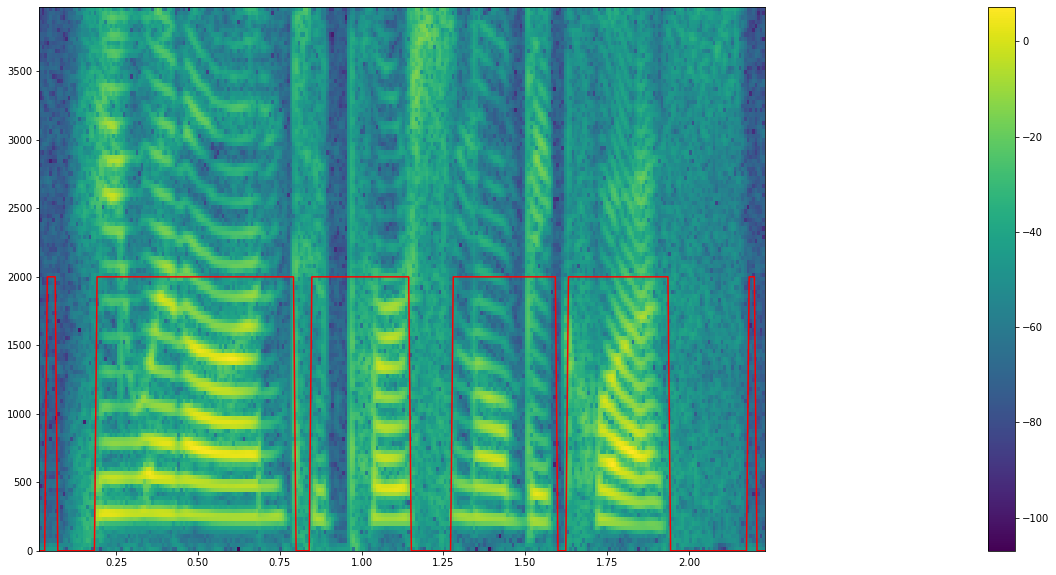

In [21]:
m_stft, v_freq, v_time = compute_stft(y, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)
plt.plot(v_time, decision_segments * 2000, 'r')

In [22]:
voiced = y[4480:4736]
unvoiced = y[15520:15776]

Text(0, 0.5, 'std')

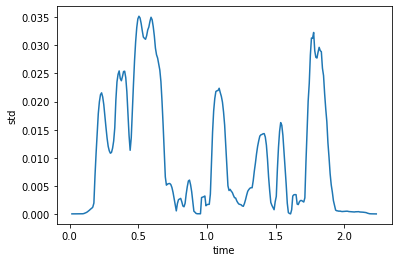

In [23]:
plt.plot(v_time, std)
plt.xlabel("time")
plt.ylabel("std")

## Fundamental Freq

/Users/christoper/programming/python/ssp/utils/code_exercise1.py:37: RuntimeWarning: divide by zero encountered in true_divide
  freqs = np.ones(periods.shape[0]) / periods


Text(0.5, 0, 'seconds')

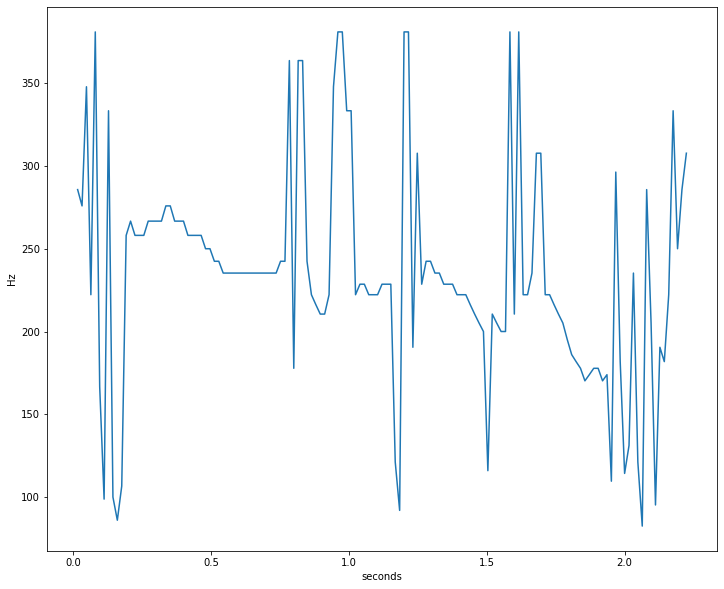

In [24]:
f0, time = get_fundamental_freq(y, sr)
plt.figure(figsize=(12,10))
plt.plot(time, f0)
plt.ylabel("Hz")
plt.xlabel("seconds")

In [25]:
def compute_lpc(frames, M):
    return np.apply_along_axis(get_a_vector, 1, frames, M)
    

In [26]:
lpcs = compute_lpc(segments, 12)
lpcs = np.insert(lpcs, 0, 1, -1)

In [27]:
lpcs[0]

array([ 1.        , -0.21991269, -0.15469758, -0.03358557, -0.04169095,
       -0.10032369,  0.0083665 ,  0.00620009, -0.04098563, -0.10729561,
        0.02409557, -0.12474787, -0.03103997])

## Excitation Signal

In [28]:
from utils.filteradaptively import filter_adaptively
from scipy.signal import freqz

In [29]:
unvoiced_ex = np.random.randn(y.shape[0])

In [30]:
voiced_ex = np.zeros(y.shape[0])
voiced_ex[::100] = 1

In [31]:
segmented_voiced_ex, _ = my_window(voiced_ex, sr, 8, 8)
segmented_unvoiced_ex, _ = my_window(unvoiced_ex, sr, 8, 8)

In [32]:
filter_state = None
all_segment_out = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced in zip(segmented_voiced_ex, segmented_unvoiced_ex, lpcs, decision_segments):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_out.append(segment_out)
all_segment_out = np.array(all_segment_out).reshape(-1)

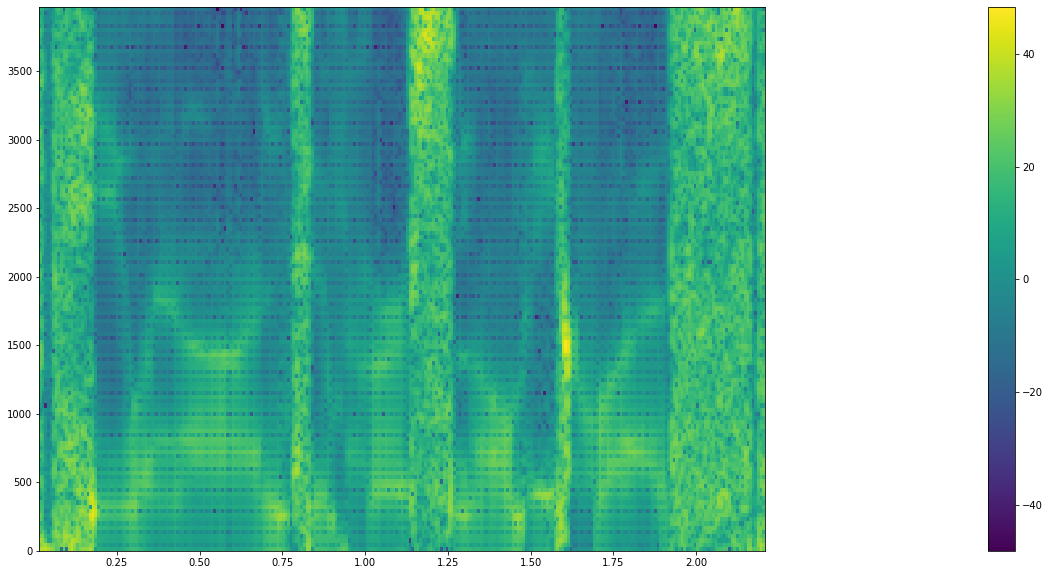

In [33]:
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

In [34]:
sounddevice.play(all_segment_out.astype(np.float64), sr)

## with gain b0

In [35]:
from scipy.signal import lfilter

In [36]:
hann_win = get_window('hann', n_length)
windowed_segments = segments * hann_win

In [37]:
b0s = []
energies = []
for s, lpc in zip(segments, lpcs):
    e_voiced = lfilter(lpc, 1, s)
    b0 = get_b0(e_voiced)
    energies.append(e_voiced)
    b0s.append(b0)
b0s = np.array(b0s)
energies = np.array(energies)

In [38]:
b0s.shape

(278,)

In [39]:
filter_state = None
all_segment_out = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced, b0 in zip(segmented_voiced_ex, segmented_unvoiced_ex, lpcs, decision_segments, b0s):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_out.append(b0 * segment_out)
all_segment_out = np.array(all_segment_out).reshape(-1)

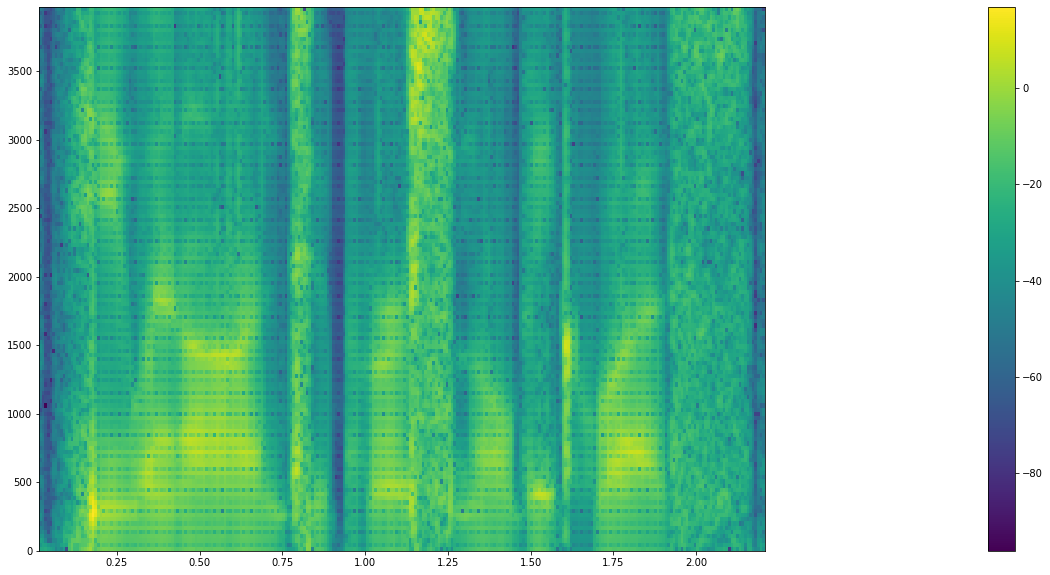

In [40]:
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

In [41]:
sounddevice.play(all_segment_out.astype(np.float64), sr)

## F0

In [42]:
ex = []
counter = 0
j = 0
for i in range(17792):
    
    if i % 128 == 0:
        f0 = f0_1[j]
        j += 1
        
    if counter > f0:
        ex.append(1)
        counter = 0
        continue
    
    ex.append(0)
    counter += 1
    
ex= np.array(ex)
segmented_voiced_ex_with_f0, _ = my_window(ex, sr, 8, 8)

In [43]:
filter_state = None
all_segment_out = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced, b0 in zip(segmented_voiced_ex_with_f0, segmented_unvoiced_ex, lpcs, decision_segments, b0s):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_out.append(b0 * segment_out)
all_segment_out = np.array(all_segment_out).reshape(-1)

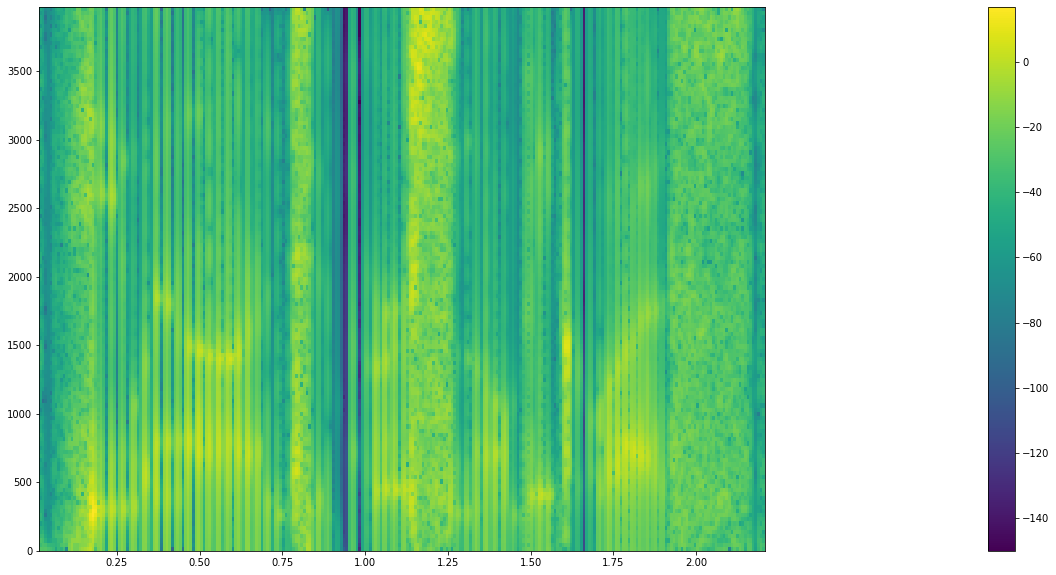

In [44]:
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

In [45]:
sounddevice.play(all_segment_out.astype(np.float64), sr)

## Quantization

In [46]:
def quantize_encoder(x, n_bits, x_range, x_center):
    max_val = x_center + (x_range / 2)
    min_val = x_center - (x_range / 2)
    step_size = (max_val - min_val) / (np.power(2, n_bits) - 1)
    print(max_val - min_val)
    print(step_size)
    return x // step_size

def quantize_decoder(idx, n_bits, x_range, x_center):
    max_val = x_center + (x_range / 2)
    min_val = x_center - (x_range / 2)
    step_size = (max_val - min_val) / (np.power(2, n_bits) - 1)
    return idx * step_size

In [47]:
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-5, 0.01, 5)

In [48]:
qidx = quantize_encoder(t, 2, 6, 0)
t_decode = quantize_decoder(qidx, 2, 6, 0)

6.0
2.0


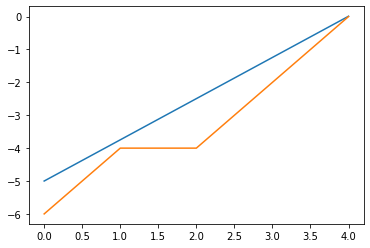

In [49]:
plt.plot(t)
plt.plot(t_decode)

In [50]:
qidx = quantize_encoder(t, 2, 6, 1)
t_decode = quantize_decoder(qidx, 2, 6, 1)

6.0
2.0


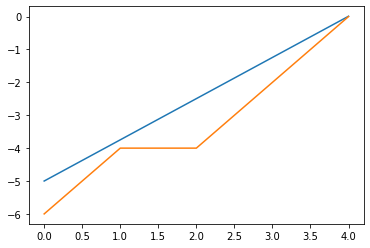

In [51]:
plt.plot(t)
plt.plot(t_decode)

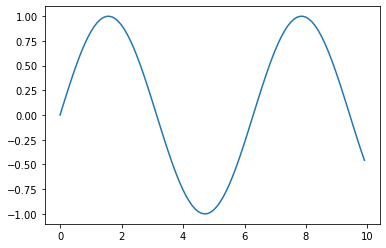

In [52]:
t        = np.arange(0, 10, 0.1);
amplitude   = np.sin(t)
plt.plot(t, amplitude)

In [53]:
qidx = quantize_encoder(amplitude, 3, 2, 1)
t_decode = quantize_decoder(qidx, 3, 2, 1)

2.0
0.2857142857142857


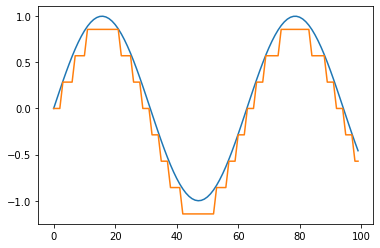

In [54]:
plt.plot(amplitude)
plt.plot(t_decode)

## Quantization F0

In [55]:
qidx = quantize_encoder(f0_1, 8, 250, 225)
f0_decode = quantize_decoder(qidx, 8, 250, 225)

250.0
0.9803921568627451


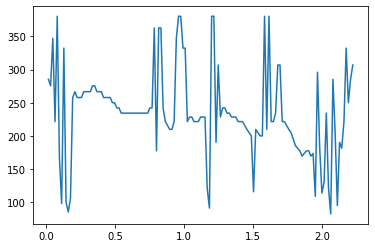

In [56]:
plt.plot(time, f0_decode)

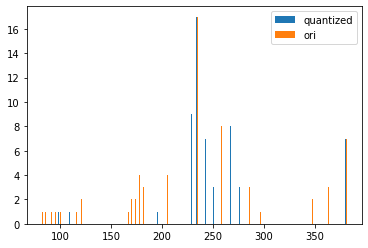

In [57]:
plt.hist(f0_decode, bins=500, label="quantized")
plt.hist(f0_1, bins=500, label="ori")
plt.legend()

## Quantized Energy

In [58]:
power.shape

(278,)

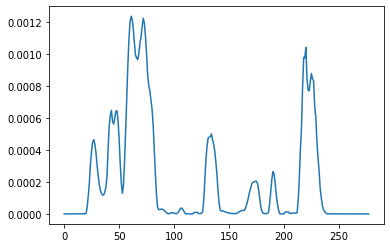

In [59]:
plt.plot(power)

In [60]:
qidx = quantize_encoder(power, 2, 0.0012, 0.0006)
power_decode = quantize_decoder(qidx, 2, 0.0012, 0.0006)

0.0012
0.00039999999999999996


(array([1.0000e+00, 1.0000e+00, 5.0000e+00, 4.6000e+01, 1.9390e+03,
        6.8063e+04, 1.0050e+03, 9.8000e+01, 7.0000e+00, 3.0000e+00]),
 array([-0.09097144, -0.07428763, -0.05760381, -0.04092   , -0.02423619,
        -0.00755237,  0.00913144,  0.02581526,  0.04249907,  0.05918289,
         0.0758667 ]),
 <a list of 10 Patch objects>)

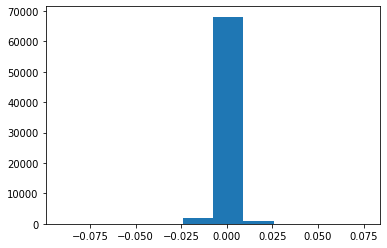

In [61]:
energies = energies.reshape(-1)
plt.hist(energies, bins=10)

In [62]:
qidx = quantize_encoder(energies, 4, 0.025, 0.0)
energies_decode = quantize_decoder(qidx, 4, 0.025, 0.0)

0.025
0.0016666666666666668


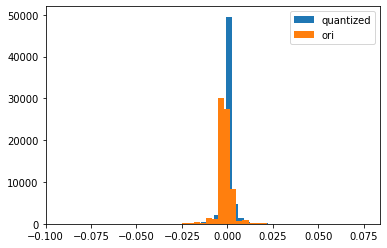

In [63]:
plt.hist(energies, bins=50, label="quantized")
plt.hist(energies_decode, bins=50, label="ori")
plt.legend()

In [64]:
log_energies = np.log10(energies)

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [65]:
log_energies = log_energies[np.isfinite(log_energies)]

(array([6.0000e+00, 1.5000e+01, 7.4000e+01, 3.6600e+02, 2.0100e+03,
        6.0110e+03, 9.4490e+03, 1.3491e+04, 5.7410e+03, 4.1600e+02]),
 array([-8.22696627, -7.51626452, -6.80556278, -6.09486103, -5.38415929,
        -4.67345754, -3.96275579, -3.25205405, -2.5413523 , -1.83065056,
        -1.11994881]),
 <a list of 10 Patch objects>)

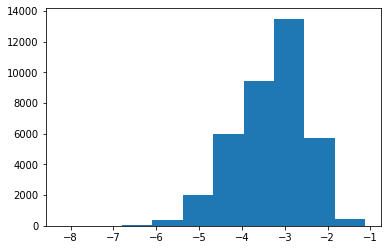

In [66]:
plt.hist(log_energies)

In [67]:
from utils.lpctools import *

In [68]:
r = np.apply_along_axis(poly2rc, 1, lpcs)

In [69]:
lars = np.apply_along_axis(rc2lar, 1, r)

(array([  11.,   26.,   77.,  108.,  263., 1904.,  738.,  103.,   79.,
          27.]),
 array([-4.52272526, -3.72083604, -2.91894681, -2.11705758, -1.31516836,
        -0.51327913,  0.2886101 ,  1.09049933,  1.89238855,  2.69427778,
         3.49616701]),
 <a list of 10 Patch objects>)

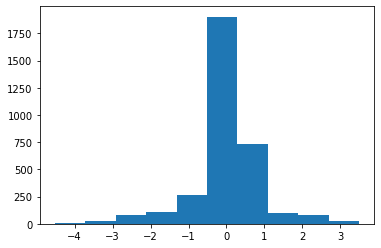

In [70]:
plt.hist(lars.reshape(-1))

In [71]:
qidx = quantize_encoder(lars, 8, 8, 0)

8.0
0.03137254901960784


In [72]:
lars_decoded = quantize_decoder(qidx, 8, 8, 0)

In [73]:
r_decoded = lar2rc(lars_decoded)
lpcs_decoded = np.apply_along_axis(rc2poly, 1, r_decoded)

In [74]:
lpcs_decoded.shape

(278, 13)

In [75]:
filter_state = None
all_segment_out = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced, energy in zip(segmented_voiced_ex_with_f0, segmented_unvoiced_ex, lpcs_decoded, decision_segments, b0s):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_out.append(energy * segment_out)
all_segment_out = np.array(all_segment_out).reshape(-1)

In [76]:
sounddevice.play(all_segment_out, sr)

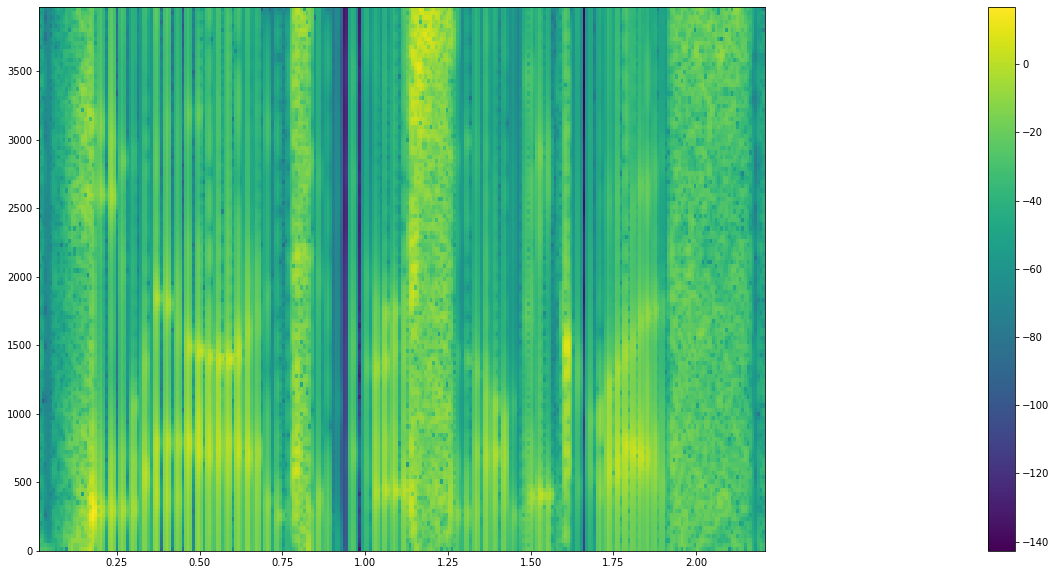

In [77]:
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)